In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from activ.readfile import load_data
from activ.pipeline import score_clusters_cv, cluster_range, filter_outliers, run_umap
from activ.data_normalization import data_normalization
import h5py
from umap import UMAP
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split, cross_val_score
import deepdish as dd

In [2]:
def read_h5(filename):
    f = h5py.File(filename, 'r')
    keys = list(f)
    print(keys)
    data = [f[x][:] for x in keys]
    return data

In [3]:
file1 = '/Users/ahyeon/Desktop/TBIanalysis/data_bm_trees.h5'
file2 = '/Users/ahyeon/Desktop/TBIanalysis/data_bm_embeddings.h5'
file3 = '/Users/ahyeon/Desktop/TBIanalysis/umap_data_bm_results.h5'

trees = read_h5(file1)
embeddings = read_h5(file2)
norm, score = read_h5(file3)

['data']
['data']
['norm_score', 'score']


(array([ 10663.,  16878.,  12857.,   7428.,   4379.,   3594.,   2622.,
           969.,    244.,     36.]),
 array([ 0.        ,  0.0826087 ,  0.16521739,  0.24782609,  0.33043478,
         0.41304348,  0.49565217,  0.57826087,  0.66086957,  0.74347826,
         0.82608696]),
 <a list of 10 Patch objects>)

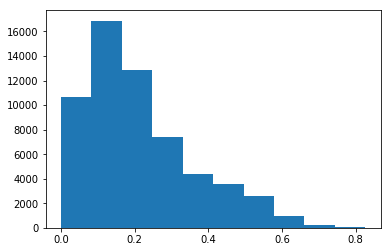

In [54]:
plt.hist(norm.reshape(np.prod(norm.shape)))

(array([ 10479.,  15127.,  12914.,   8351.,   3773.,   3023.,   3475.,
          1632.,    809.,     87.]),
 array([ 0.   ,  0.075,  0.15 ,  0.225,  0.3  ,  0.375,  0.45 ,  0.525,
         0.6  ,  0.675,  0.75 ]),
 <a list of 10 Patch objects>)

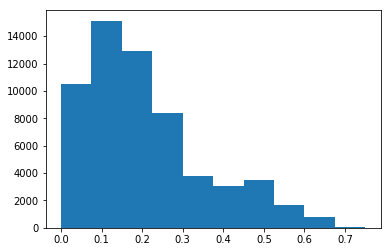

In [55]:
plt.hist(score.reshape(np.prod(score.shape)))

(51, 9, 13)

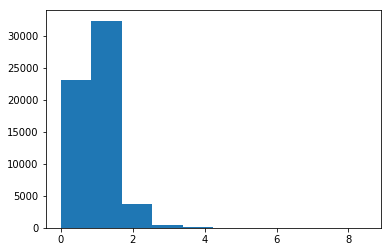

In [4]:
score2 = score/norm.mean(axis=-1, keepdims=True)
plt.hist(score2.reshape(np.prod(score2.shape)))
med_score = np.median(score2, axis=-1)
mean_score = np.mean(score2,axis=-1)
mean_score.shape

In [5]:
medscore = mean_score.mean(axis=0)

In [6]:
np.where(medscore > 1.06)

(array([4, 6]), array([8, 6]))

Text(0.5,1,'Median Prediction Accuracy')

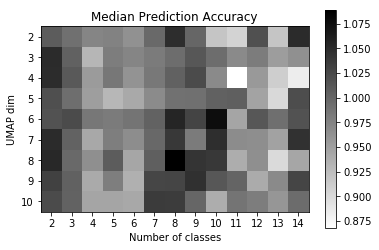

In [7]:
f, ax = plt.subplots(1)
im = ax.imshow(medscore, cmap='gray_r')
f.colorbar(im)
clusters = np.arange(2,15)
umap_dims = np.arange(2,11)
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters)
ax.set_xlabel('Number of classes')
ax.set_yticks(np.arange(len(umap_dims)))
ax.set_yticklabels(umap_dims)
ax.set_ylabel('UMAP dim')
ax.set_title('Median Prediction Accuracy')

In [8]:
filename = '/Users/ahyeon/Desktop/TBIanalysis/data/data.h5'
with h5py.File(filename, 'r') as f:
    data_bm = f['data_matrix_subset_biomarker'][:].T
    data_oc = f['data_matrix_subset_outcome'][:].T
    feature_bm = f['feature_name_subset_biomarker'][:]
    feature_oc = f['feature_name_subset_outcome'][:]
    pid = f['patient_id'][:]

(247, 100)


(array([ 28.,  24.,  30.,   0.,  39.,  37.,   0.,  45.,  23.,  21.]),
 array([ 0. ,  0.7,  1.4,  2.1,  2.8,  3.5,  4.2,  4.9,  5.6,  6.3,  7. ]),
 <a list of 10 Patch objects>)

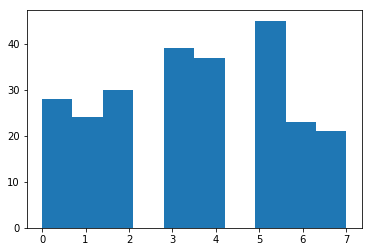

In [25]:
k=8
c=8
confmat = np.zeros((8,8))

seed=0

embedding = run_umap(data_oc, 100, n_neighbors=10,min_dist=0.001, random_state=seed)
print(embedding.shape)
Z = hierarchy.linkage(embedding, 'ward', optimal_ordering=True)
labels = hierarchy.cut_tree(Z, n_clusters=c).reshape(247)
plt.hist(labels)

In [26]:
rf = RFC(100, random_state=seed)
testX, trainX, testY, trainY = train_test_split(data_oc, labels, test_size=0.2, random_state=seed)
rf.fit(trainX, trainY)
predictions = rf.predict(testX)
prob = rf.predict_proba(testX)
for p,a in zip(predictions, testY):
    confmat[a,p] += 1
confmat

array([[ 15.,   0.,   0.,   2.,   0.,   0.,   1.,   0.],
       [  3.,   8.,   0.,   0.,   1.,   4.,   3.,   0.],
       [  7.,   0.,   0.,  19.,   0.,   1.,   0.,   1.],
       [  5.,   0.,   0.,  24.,   0.,   1.,   0.,   1.],
       [ 10.,   0.,   0.,   4.,  14.,   2.,   0.,   1.],
       [ 14.,   0.,   0.,   8.,   3.,  10.,   1.,   1.],
       [  4.,   1.,   0.,   0.,   0.,   0.,  11.,   0.],
       [  0.,   0.,   0.,   5.,   5.,   2.,   0.,   5.]])

In [27]:
confmat/confmat.sum(axis=1, keepdims=True)

array([[ 0.83333333,  0.        ,  0.        ,  0.11111111,  0.        ,
         0.        ,  0.05555556,  0.        ],
       [ 0.15789474,  0.42105263,  0.        ,  0.        ,  0.05263158,
         0.21052632,  0.15789474,  0.        ],
       [ 0.25      ,  0.        ,  0.        ,  0.67857143,  0.        ,
         0.03571429,  0.        ,  0.03571429],
       [ 0.16129032,  0.        ,  0.        ,  0.77419355,  0.        ,
         0.03225806,  0.        ,  0.03225806],
       [ 0.32258065,  0.        ,  0.        ,  0.12903226,  0.4516129 ,
         0.06451613,  0.        ,  0.03225806],
       [ 0.37837838,  0.        ,  0.        ,  0.21621622,  0.08108108,
         0.27027027,  0.02702703,  0.02702703],
       [ 0.25      ,  0.0625    ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.6875    ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.29411765,  0.29411765,
         0.11764706,  0.        ,  0.29411765]])

Text(0.5,1,'Confusion Matrix Dim = 8')

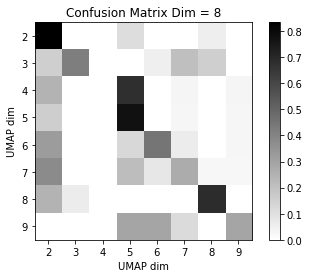

In [29]:
f, ax = plt.subplots(1)
im = ax.imshow(confmat/confmat.sum(axis=1, keepdims=True), cmap='gray_r')
f.colorbar(im)
umap_dims = np.arange(2,10)
ax.set_xticks(np.arange(len(umap_dims)))
ax.set_xticklabels(umap_dims)
ax.set_xlabel('UMAP dim')
ax.set_yticks(np.arange(len(umap_dims)))
ax.set_yticklabels(umap_dims)
ax.set_ylabel('UMAP dim')
ax.set_title('Confusion Matrix Dim = 8')